In [1]:
%cd "/content/drive/MyDrive/My Projects/face-verification-with-siamese-network"

/content/drive/MyDrive/My Projects/face-verification-with-siamese-network


In [2]:
!pip install import-ipynb

In [3]:
import import_ipynb
import config
import utils
from imutils import paths
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.utils import shuffle
import cv2
import os
from siamese_network import build_siamese_network
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
import numpy as np

importing Jupyter notebook from config.ipynb
importing Jupyter notebook from utils.ipynb
importing Jupyter notebook from siamese_network.ipynb


In [4]:
# define a path for data and list all of the images
# in the path and then shuffle them
path = "extracted-celeb-data"
imagePaths = list(paths.list_images(path))
imagePaths = shuffle(imagePaths)

In [5]:
# initialize data list for reading and storing images and
# intensity values and initialize labels list to store 
# the image labels 
data = []
labels = []

# loop through the list  image paths
for i in imagePaths:
  # read the label from the path and append it to labels list
  label = i.split(os.path.sep)[-2]
  labels.append(label)
  # read the current image and convert it into gray scale and
  # then append it to the data list
  image = cv2.imread(i , 0)
  image = img_to_array(image)
  data.append(image)

In [6]:
# convert the lists into Numpy array format
data = np.array(data , dtype = "float32")
labels = np.array(labels)

# for convenience we drop the color channel of the images
data = np.squeeze(data, axis = -1)

In [7]:
# define a dictionary to map each and every label into 
# a specific number
label_dict = {
    "George_Clonney" : 0,
    "Nicolas_Cage" : 1,
    "Tom_Cruise" : 2,
    "Matt_Damon" : 3,
}

labels = list(map(lambda x : label_dict[x], labels))

In [8]:
# split the data into X and y and train set and
# test set with 80% ratio
X_train = np.array(data[:int(.8 * len(data))])
X_test = np.array(data[int(.8 * len(data)):])
y_train = np.array(labels[:int(.8 * len(data))])
y_test = np.array(labels[int(.8 * len(data)):])

In [9]:
X_train = X_train / 255.0
X_test = X_test / 255.0

X_train = np.expand_dims(X_train , axis = -1)
X_test = np.expand_dims(X_test , axis = -1)

(pairTrain, labelTrain) = utils.make_pairs(X_train, y_train)
(pairTest, labelTest) = utils.make_pairs(X_test, y_test)

In [11]:
# to pass in an image pair into network we create two
# "Input"s
imgA = Input(shape=config.IMG_SHAPE)
imgB = Input(shape=config.IMG_SHAPE)

# instantiate our model
featureExtractor = build_siamese_network(config.IMG_SHAPE)

# in order to have two networks with shared weights
# and with the same structure, we have to create our
# both networks from one instance 
featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)

In [12]:
distance = Lambda(utils.euclidean_distance)([featsA, featsB])
model = Model(inputs=[imgA, imgB], outputs=distance)

In [13]:
OPT = Adam(learning_rate = config.LEARNING_RATE)
callbacks_list = [utils.lrate]

model.compile(loss=utils.contrastive_loss , optimizer=OPT)

history = model.fit(
	[pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
	validation_data=([pairTest[:, 0], pairTest[:, 1]], labelTest[:]),
	batch_size=config.BATCH_SIZE, 
	epochs=config.EPOCHS,
	callbacks = callbacks_list
)

Epoch 1/50
32/32 [==============================] - 3s 30ms/step - loss: 1.5892 - val_loss: 0.4101
Epoch 2/50
32/32 [==============================] - 0s 12ms/step - loss: 0.4566 - val_loss: 0.3785
Epoch 3/50
32/32 [==============================] - 0s 11ms/step - loss: 0.3163 - val_loss: 0.3416
Epoch 4/50
32/32 [==============================] - 0s 12ms/step - loss: 0.2853 - val_loss: 0.3020
Epoch 5/50
32/32 [==============================] - 0s 11ms/step - loss: 0.2558 - val_loss: 0.2698
Epoch 6/50
32/32 [==============================] - 0s 11ms/step - loss: 0.2306 - val_loss: 0.2498
Epoch 7/50
32/32 [==============================] - 0s 11ms/step - loss: 0.2329 - val_loss: 0.2184
Epoch 8/50
32/32 [==============================] - 0s 11ms/step - loss: 0.2019 - val_loss: 0.2177
Epoch 9/50
32/32 [==============================] - 0s 12ms/step - loss: 0.1884 - val_loss: 0.2140
Epoch 10/50
32/32 [==============================] - 0s 11ms/step - loss: 0.1743 - val_loss: 0.1906
Epoch 11/

INFO:tensorflow:Assets written to: output/siamese-model/assets


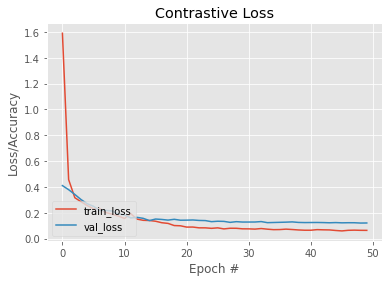

In [15]:
model.save(config.MODEL_PATH)

utils.plot_training(history, config.PLOT_PATH)